In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

### Simulation for building model

In [4]:
smiley = pd.read_csv('../data/smiley.csv', index_col = 0)
smiley.columns = ['x', 'y', 'classes']

In [5]:
import plotly.express as px

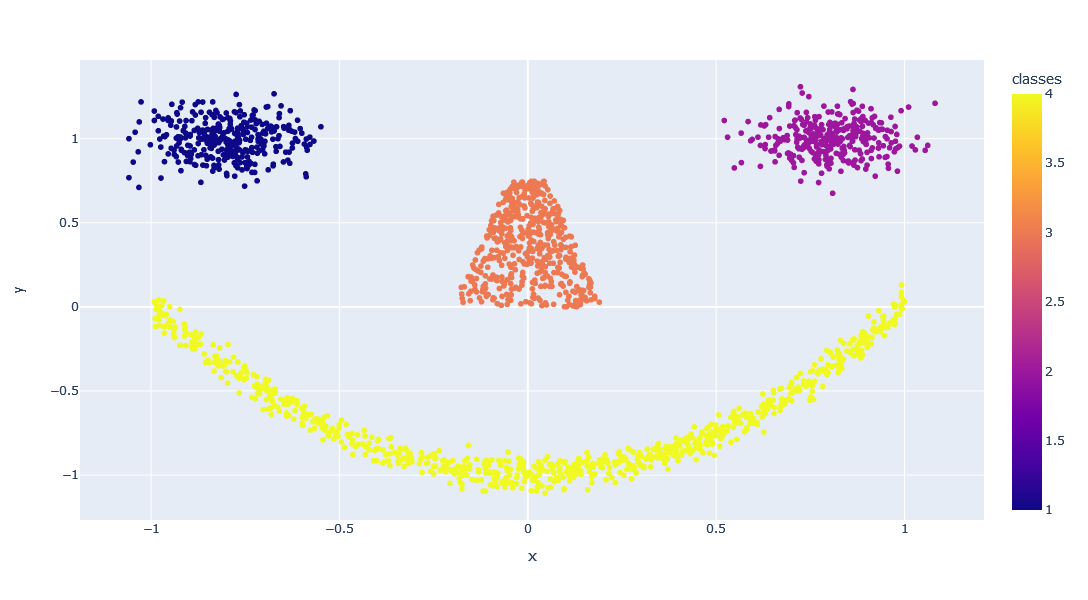

In [6]:
fig = px.scatter(smiley, x = 'x', y = 'y', color = 'classes', width = 600, height = 600)
fig

In [7]:
# Sampling from each individual column then append together
def sampling(data, n, random_state):
    synth_data = pd.DataFrame()
    i = 0
    for column in data.columns:
        synth_data[column] = data[column].sample(n = n, replace = True, random_state = random_state + i * 10).reset_index(drop = True)
        i += 1
    return synth_data

In [8]:
synth_smiley = sampling(smiley, 2000, 30025)

In [9]:
# encode features, run once only
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse = False)
smiley_targets_enc = enc.fit_transform(smiley[['classes']])
enc = OneHotEncoder(sparse = False)
synths_targets_enc = enc.fit_transform(synth_smiley[['classes']])

In [10]:
smiley[['0', '1', '2', '3']] = smiley_targets_enc
smiley.drop(['classes'], axis = 1, inplace = True)
synth_smiley[['0', '1', '2', '3']] = synths_targets_enc
synth_smiley.drop(['classes'], axis = 1, inplace = True)

In [11]:
smiley['label'] = 1
synth_smiley['label'] = 0
X = pd.concat((smiley, synth_smiley))
X = X.reset_index().drop('index', axis = 1)

### XGBoost construction

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :-1], X.iloc[:, -1], test_size = 0.3, random_state = 30025)

In [13]:
import xgboost as xgb

In [14]:
model = xgb.XGBClassifier(random_state = 1, n_estimators = 50)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [15]:
synth_smiley.columns

Index(['x', 'y', '0', '1', '2', '3', 'label'], dtype='object')

In [16]:
preds = model.predict(X_test)

In [17]:
np.sum(preds == y_test)/len(y_test)

0.9308333333333333

### Get booster method, do some information extraction

In [18]:
booster = model.get_booster()

In [19]:
#get all real datapoints
indices = y_train[y_train == 1].index
real_df = X_train.loc[indices].reset_index().drop('index', axis = 1)

In [20]:
leaves = booster.predict(xgb.DMatrix(real_df), pred_leaf = True)
contribs = booster.predict(xgb.DMatrix(real_df), pred_contribs = True, strict_shape = True)

In [21]:
booster.dump_model('xgb_model.txt', with_stats = True)

In [22]:
# get df of trees information
tree_df = booster.trees_to_dataframe()

In [23]:
# split into each idv tree
trees_grouped = tree_df.groupby('Tree')
trees = [trees_grouped.get_group(x).reset_index().drop('index', axis = 1) for x in trees_grouped.groups]

In [24]:
mcr_columns = []
for feature in real_df.columns:
    mcr_columns.append(feature + ' lower')
    mcr_columns.append(feature + ' upper')

In [25]:
abs_min = real_df.min()
abs_max = real_df.max()

In [26]:
min_val = -10000
max_val = 10000
original_bounds = {}
splits = []
for i in range(0, len(mcr_columns)):
    mcr_column = mcr_columns[i].split(' ')
    if i % 2 == 0:
        original_bounds[mcr_columns[i]] = abs_min[mcr_column[0]]
    else:
        original_bounds[mcr_columns[i]] = abs_max[mcr_column[0]]
bounds = original_bounds
for split in splits:
    if split[2] == '<':
        check = split[0] + ' upper'
        if split[1] <= bounds[check]:
            bounds[check] = split[1]
    else:
        check = split[0] + ' lower'
        if split[1] >= bounds[check]:
            bounds[check] = split[1]
original_bounds

{'x lower': -1.05867667205094,
 'x upper': 1.08101466766576,
 'y lower': -1.09587769357287,
 'y upper': 1.30873238401266,
 '0 lower': 0.0,
 '0 upper': 1.0,
 '1 lower': 0.0,
 '1 upper': 1.0,
 '2 lower': 0.0,
 '2 upper': 1.0,
 '3 lower': 0.0,
 '3 upper': 1.0}

In [27]:
original_bounds = {}
for i in range(0, len(mcr_columns)):
    mcr_column = mcr_columns[i].split(' ')
    if i % 2 == 0:
        original_bounds[mcr_columns[i]] = abs_min[mcr_column[0]]
    else:
        original_bounds[mcr_columns[i]] = abs_max[mcr_column[0]]
original_bounds

{'x lower': -1.05867667205094,
 'x upper': 1.08101466766576,
 'y lower': -1.09587769357287,
 'y upper': 1.30873238401266,
 '0 lower': 0.0,
 '0 upper': 1.0,
 '1 lower': 0.0,
 '1 upper': 1.0,
 '2 lower': 0.0,
 '2 upper': 1.0,
 '3 lower': 0.0,
 '3 upper': 1.0}

In [28]:
import copy

In [32]:
original_bounds = {}
mcr_df = pd.DataFrame(columns = mcr_columns)
for i in range(0, len(mcr_columns)):
    mcr_column = mcr_columns[i].split(' ')
    if i % 2 == 0:
        original_bounds[mcr_columns[i]] = abs_min[mcr_column[0]]
    else:
        original_bounds[mcr_columns[i]] = abs_max[mcr_column[0]]
for index, row in real_df.iterrows():
    bounds = copy.deepcopy(original_bounds)
    splits = []
    for i in range(0, len(trees)):
        cur_tree = trees[i]
        node = cur_tree.loc[cur_tree['Node'] == 0].iloc[0]
        feature = node['Feature']
        next_node = 0
        while feature != 'Leaf':
            value = row[feature]
            split = [feature, node['Split']]
            if value < node['Split']:
                next_node = node['Yes']
                split.append('<')
            else:
                next_node = node['No']
                split.append('>=')
            node = tree_df[tree_df['ID'] == next_node].iloc[0]
            split.append(node['Node'])
            splits.append(split)
            feature = node['Feature']
    for split in splits:
        if split[2] == '<':
            check = split[0] + ' upper'
            if split[1] <= bounds[check]:
                bounds[check] = split[1]
        else:
            check = split[0] + ' lower'
            if split[1] >= bounds[check]:
                bounds[check] = split[1]
    mcr_df.loc[len(mcr_df)] = bounds

KeyboardInterrupt: 

mcr_df.to_csv("smiley_mcr.csv")

In [ ]:
mcr_df = pd.read_csv("smiley_mcr.csv", index_col = 0)

In [ ]:
sample = mcr_df.sample(n = 2000, replace = True)

In [ ]:
sample

In [ ]:
sample_data = []
for index, row in sample.iterrows():
    x = (row['x upper'] - row['x lower']) * np.random.random_sample() + row['x lower']
    y = (row['y upper'] - row['y lower']) * np.random.random_sample() + row['y lower']
    if row['0 upper'] == 1 and row['0 lower'] == 0.5:
        label = 0
    elif row['1 upper'] == 1 and row['1 lower'] == 0.5:
        label = 1
    elif row['2 upper'] == 1 and row['2 lower'] == 0.5:
        label = 2
    else:
        label = 3
    sample_data.append([x, y, label])
gen = pd.DataFrame(sample_data)
gen.columns = ['x', 'y', 'classes']

In [ ]:
gen

In [ ]:
fig = px.scatter(gen, x = 'x', y = 'y', color = 'classes', width = 600, height = 600)
fig

In [75]:
enc = OneHotEncoder(sparse = False)
gen_enc = enc.fit_transform(gen[['classes']])
gen[['0', '1', '2', '3']] = gen_enc
gen.drop(['classes'], axis = 1, inplace = True)
gen['label'] = 0

In [76]:
gen

x         y    0    1    2    3  label
0    -0.034068  0.496732  0.0  0.0  1.0  0.0      0
1    -0.152412  0.341276  0.0  0.0  1.0  0.0      0
2     0.802488  1.082840  0.0  1.0  0.0  0.0      0
3    -0.096889  0.151637  0.0  0.0  1.0  0.0      0
4     0.805172 -0.370455  0.0  0.0  0.0  1.0      0
...        ...       ...  ...  ...  ...  ...    ...
1995 -0.736555  1.097451  1.0  0.0  0.0  0.0      0
1996  0.914967  1.142542  0.0  1.0  0.0  0.0      0
1997 -0.895929  1.203933  1.0  0.0  0.0  0.0      0
1998  0.731301  0.960796  0.0  1.0  0.0  0.0      0
1999  0.059284  0.612717  0.0  0.0  1.0  0.0      0

[2000 rows x 7 columns]

In [77]:
X2 = pd.concat((smiley, gen))

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X2.iloc[:, :-1], X2.iloc[:, -1], test_size = 0.3, random_state = 30025)

In [116]:
model2 = xgb.XGBClassifier(n_estimators = 50, random_state = 20)
model2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=20, ...)

In [117]:
preds = model2.predict(X_test)

In [118]:
np.sum(preds == y_test)/len(y_test)

0.49

### Second round of sampling

In [82]:
booster = model2.get_booster()

In [83]:
#get all real datapoints
indices = y_train[y_train == 1].index
real_df = X_train.loc[indices].reset_index().drop('index', axis = 1)

In [84]:
leaves = booster.predict(xgb.DMatrix(real_df), pred_leaf = True)
contribs = booster.predict(xgb.DMatrix(real_df), pred_contribs = True, strict_shape = True)

In [85]:
booster.dump_model('xgb_model2.txt', with_stats = True)

In [86]:
# get df of trees information
tree_df = booster.trees_to_dataframe()

In [87]:
# split into each idv tree
trees_grouped = tree_df.groupby('Tree')
trees = [trees_grouped.get_group(x).reset_index().drop('index', axis = 1) for x in trees_grouped.groups]

In [88]:
mcr_columns = []
for feature in real_df.columns:
    mcr_columns.append(feature + ' lower')
    mcr_columns.append(feature + ' upper')

In [89]:
abs_min = real_df.min()
abs_max = real_df.max()

In [90]:
original_bounds = {}
mcr_df = pd.DataFrame(columns = mcr_columns)
for i in range(0, len(mcr_columns)):
    mcr_column = mcr_columns[i].split(' ')
    if i % 2 == 0:
        original_bounds[mcr_columns[i]] = abs_min[mcr_column[0]]
    else:
        original_bounds[mcr_columns[i]] = abs_max[mcr_column[0]]
for index, row in real_df.iterrows():
    bounds = copy.deepcopy(original_bounds)
    splits = []
    for i in range(0, len(trees)):
        cur_tree = trees[i]
        node = cur_tree.loc[cur_tree['Node'] == 0].iloc[0]
        feature = node['Feature']
        next_node = 0
        while feature != 'Leaf':
            value = row[feature]
            split = [feature, node['Split']]
            if value < node['Split']:
                next_node = node['Yes']
                split.append('<')
            else:
                next_node = node['No']
                split.append('>=')
            node = tree_df[tree_df['ID'] == next_node].iloc[0]
            split.append(node['Node'])
            splits.append(split)
            feature = node['Feature']
    for split in splits:
        if split[2] == '<':
            check = split[0] + ' upper'
            if split[1] <= bounds[check]:
                bounds[check] = split[1]
        else:
            check = split[0] + ' lower'
            if split[1] >= bounds[check]:
                bounds[check] = split[1]
    mcr_df.loc[len(mcr_df)] = bounds

In [91]:
mcr_df.to_csv("smiley_mcr2.csv")

In [92]:
sample = mcr_df.sample(n = 2000, replace = True)

In [93]:
sample

x lower   x upper   y lower   y upper  0 lower  0 upper  1 lower  \
2103 -0.307514 -0.280343 -0.934389 -0.930505      0.0      1.0      0.0   
461  -0.002990  0.003737  0.690463  0.741269      0.0      1.0      0.0   
1533 -0.242278 -0.108946  0.052150  0.054026      0.0      1.0      0.0   
1870  0.691792  0.710469  1.073363  1.075189      0.0      1.0      0.0   
807   0.631229  0.651277 -0.580209 -0.570060      0.0      1.0      0.0   
...        ...       ...       ...       ...      ...      ...      ...   
2299 -0.729711 -0.723282  1.163352  1.169428      0.0      1.0      0.0   
512   0.901102  0.909675  0.912470  0.919373      0.0      1.0      0.0   
129   0.506966  0.512756 -0.645439 -0.639261      0.0      1.0      0.0   
823   0.049397  0.061147 -0.928322 -0.925398      0.0      1.0      0.0   
1638  0.038218  0.044223  0.741269  0.793792      0.0      1.0      0.0   

      1 upper  2 lower  2 upper  3 lower  3 upper  
2103      1.0      0.0      1.0      0.0      1.0  
461       1.0      0.0      1.0      0.0      1.0  
1533      1.0      0.0      1.0      0.0      1.0  
1870      1.0      0.0      1.0      0.0      1.0  
807       1.0      0.0      1.0      0.0      1.0  
...       ...      ...      ...      ...      ...  
2299      1.0      0.0      1.0      0.0      1.0  
512       1.0      0.0      1.0      0.0      1.0  
129       1.0      0.0      1.0      0.0      1.0  
823       1.0      0.0      1.0      0.0      1.0  
1638      1.0      0.0      1.0      0.0      1.0  

[2000 rows x 12 columns]

In [94]:
sample_data = []
for index, row in sample.iterrows():
    x = (row['x upper'] - row['x lower']) * np.random.random_sample() + row['x lower']
    y = (row['y upper'] - row['y lower']) * np.random.random_sample() + row['y lower']
    if row['0 upper'] == 1 and row['0 lower'] == 0.5:
        label = 0
    elif row['1 upper'] == 1 and row['1 lower'] == 0.5:
        label = 1
    elif row['2 upper'] == 1 and row['2 lower'] == 0.5:
        label = 2
    else:
        label = 3
    sample_data.append([x, y, label])
gen = pd.DataFrame(sample_data)
gen.columns = ['x', 'y', 'classes']

In [95]:
gen

x         y  classes
0    -0.280702 -0.934284        3
1    -0.000393  0.722742        3
2    -0.128049  0.052536        3
3     0.708191  1.075109        3
4     0.647451 -0.573361        3
...        ...       ...      ...
1995 -0.726958  1.164892        3
1996  0.904413  0.915980        3
1997  0.507883 -0.645205        3
1998  0.050857 -0.926005        3
1999  0.043107  0.779234        3

[2000 rows x 3 columns]

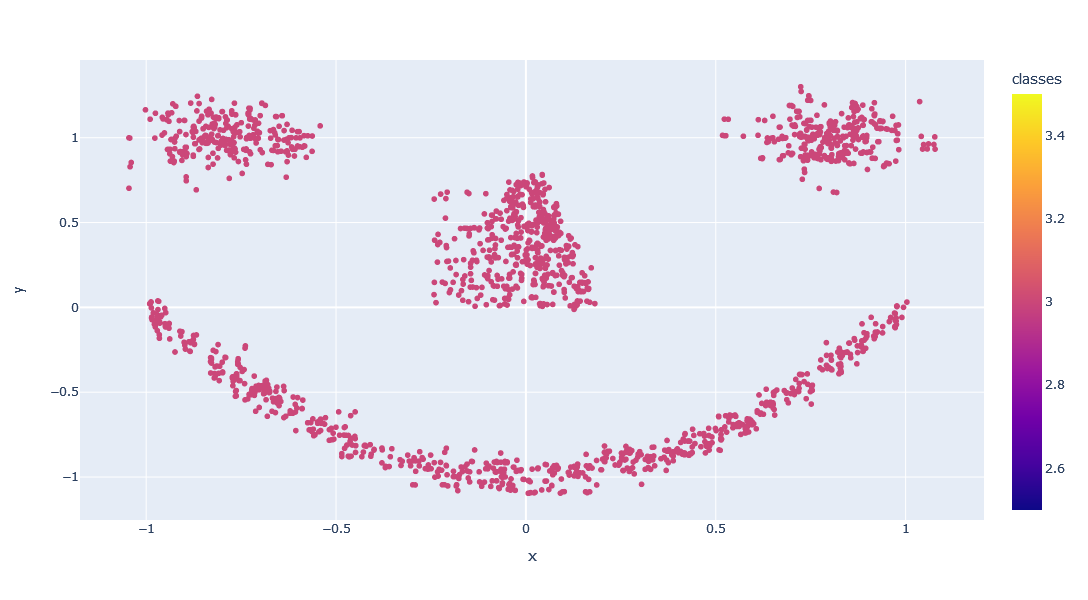

In [96]:
fig = px.scatter(gen, x = 'x', y = 'y', color = 'classes', width = 600, height = 600)
fig

In [110]:
enc = OneHotEncoder(sparse = False)
gen_enc = enc.fit_transform(gen[['classes']])
gen[['0', '1', '2', '3']] = gen_enc
gen.drop(['classes'], axis = 1, inplace = True)
gen['label'] = 0

ValueError: Columns must be same length as key

In [111]:
gen

x         y  classes
0    -0.280702 -0.934284        3
1    -0.000393  0.722742        3
2    -0.128049  0.052536        3
3     0.708191  1.075109        3
4     0.647451 -0.573361        3
...        ...       ...      ...
1995 -0.726958  1.164892        3
1996  0.904413  0.915980        3
1997  0.507883 -0.645205        3
1998  0.050857 -0.926005        3
1999  0.043107  0.779234        3

[2000 rows x 3 columns]

In [77]:
X2 = pd.concat((smiley, gen))

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X2.iloc[:, :-1], X2.iloc[:, -1], test_size = 0.3, random_state = 30025)

In [112]:
model2 = xgb.XGBClassifier(n_estimators = 50, random_state = 20)
model2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=20, ...)

In [113]:
preds = model2.predict(X_test)

In [114]:
np.sum(preds == y_test)/len(y_test)

0.49

In [115]:
trees

[    Tree  Node    ID Feature     Split  Yes    No Missing      Gain   Cover  \
 0      0     0   0-0       y -0.942255  0-1   0-2     0-1  4.404387  700.00   
 1      0     1   0-1       y -0.953752  0-3   0-4     0-3  7.458011   54.75   
 2      0     2   0-2       y  0.955103  0-5   0-6     0-5  3.854835  645.25   
 3      0     3   0-3       y -1.087716  0-7   0-8     0-7  4.466941   48.00   
 4      0     4   0-4       x  0.077390  0-9  0-10     0-9  0.296015    6.75   
 ..   ...   ...   ...     ...       ...  ...   ...     ...       ...     ...   
 56     0    56  0-56    Leaf       NaN  NaN   NaN     NaN  0.200000    1.25   
 57     0    57  0-57    Leaf       NaN  NaN   NaN     NaN -0.300000    1.00   
 58     0    58  0-58    Leaf       NaN  NaN   NaN     NaN  0.088696   56.50   
 59     0    59  0-59    Leaf       NaN  NaN   NaN     NaN -0.284211    3.75   
 60     0    60  0-60    Leaf       NaN  NaN   NaN     NaN  0.008798   84.25   
 
     Category  
 0        NaN  
 1    